In [1]:
import logging
from typing import Any, Callable, List, Literal, Type, Dict, Union
from pathlib import Path
import argparse
import glob
import pickle
import os
import json
import mteb

import numpy as np
import torch
import mteb

from utils.misc.model_dataloader_utils import get_model_path, model_name_to_sizes
from utils.model_definitions.mteb_automodel_wrapper import AutoModelWrapper, ModelSpecifications

In [117]:
def handle_special_mteb_results(data):
    special_benchmarks = ['STS17', 'AmazonCounterfactualClassification']

    if data.get('task_name') not in special_benchmarks:
        assert len(data.get('scores').get('test')) == 1, \
            f"Expected 1 score for {data.get('task_name')}, got {len(data.get('scores').get('test'))}"
        
        return data.get('scores').get('test')[0].get('main_score')
    
    if data.get('task_name') == 'STS17':
        scores = data.get('scores', {}).get('test', [])
        filtered_scores = [
            score for score in scores 
            if score.get('languages') == ['eng-Latn']
        ]
        assert len(filtered_scores) == 1
        return filtered_scores[0].get('main_score')

    elif data.get('task_name') == 'AmazonCounterfactualClassification':
        scores = data.get('scores', {}).get('test', [])
        filtered_scores = [
            score for score in scores 
            if score.get('hf_subset') in ['en', 'en-ext']
        ]
        assert len(filtered_scores) == 2

        english_score = filtered_scores[0].get('main_score')
        english_ext_score = filtered_scores[1].get('main_score') # harder superset, described in Sec 3.3 of https://aclanthology.org/2021.emnlp-main.568.pdf

        return (english_score + english_ext_score) / 2
    else:
        raise ValueError(f"Special benchmark handling for {data.get('task_name')} not found")
    
def get_task_type_from_task_name(task_name: str):
    mteb_task = mteb.get_task(task_name)
    return mteb_task.metadata.type

def get_dataset_name_from_task_name(task_name: str):
    mteb_task = mteb.get_task(task_name)
    return mteb_task.metadata.dataset['path']
        
def load_layerwise_results_for_specific_model(model_specs: ModelSpecifications):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    
    results = {}
    
    # load metrics
    results['metrics'] = {}
    metrics_load_dir = f"results/{model_family}/{model_size}/{revision}/metrics/"
    for dataset_dir in glob.glob(f"{metrics_load_dir}/**", recursive=True):
        if os.path.isdir(dataset_dir):
            dataset_name = os.path.relpath(dataset_dir, metrics_load_dir)

            results['metrics'][dataset_name] = {}
            for file_path in glob.glob(f"{dataset_dir}/*.pkl"):
                with open(file_path, "rb") as f:
                    key = os.path.basename(file_path)[:-4]
                    results['metrics'][dataset_name][key] = pickle.load(f)
            
            if results['metrics'][dataset_name] == {}:
                # pop superfolders
                results['metrics'].pop(dataset_name)

    # load mteb metrics
    mteb_load_dir = f"results/{model_family}/{model_size}/{revision}/mteb/"
    results['mteb'] = {}
    for layer_dir in glob.glob(f"{mteb_load_dir}/layer_*"):
        for json_file in glob.glob(f"{layer_dir}/*.json"):
            dataset_name = os.path.basename(json_file)[:-5]
            
            if dataset_name == 'model_meta':
                continue

            if dataset_name not in results['mteb']:
                results['mteb'][dataset_name] = {}
                results['mteb'][dataset_name]['scores'] = []
                results['mteb'][dataset_name]['time_elapsed'] = []
            with open(json_file, 'r') as f:
                data = json.load(f)
                main_score = handle_special_mteb_results(data)
                results['mteb'][dataset_name]['scores'].append(main_score)

                time_elapsed = data.get('evaluation_time', None)
                results['mteb'][dataset_name]['time_elapsed'].append(time_elapsed)
                
                if 'task_type' not in results['mteb'][dataset_name]:
                    results['mteb'][dataset_name]['task_type'] = get_task_type_from_task_name(dataset_name)

    # # add new metric that is dime divided by dataset entropy
    # for dataset_name, dataset_data in results['metrics'].items():

    #     dataset_data['dime_over_entropy'] = {}
    #     for normalization_type, normalization_data in dataset_data['dime'].items():
    #         dataset_data['dime_over_entropy'][normalization_type] = np.array(dataset_data['dime'][normalization_type]) / np.array(dataset_data['entropy_dataset'][normalization_type])
    
    return results

In [115]:
model_family = 'Pythia'
model_size = '14m'
revision = 'main'

model_specs = ModelSpecifications(model_family, model_size, revision=revision)
results = load_layerwise_results_for_specific_model(model_specs)

# Time Taken To Evaluate Each Layer

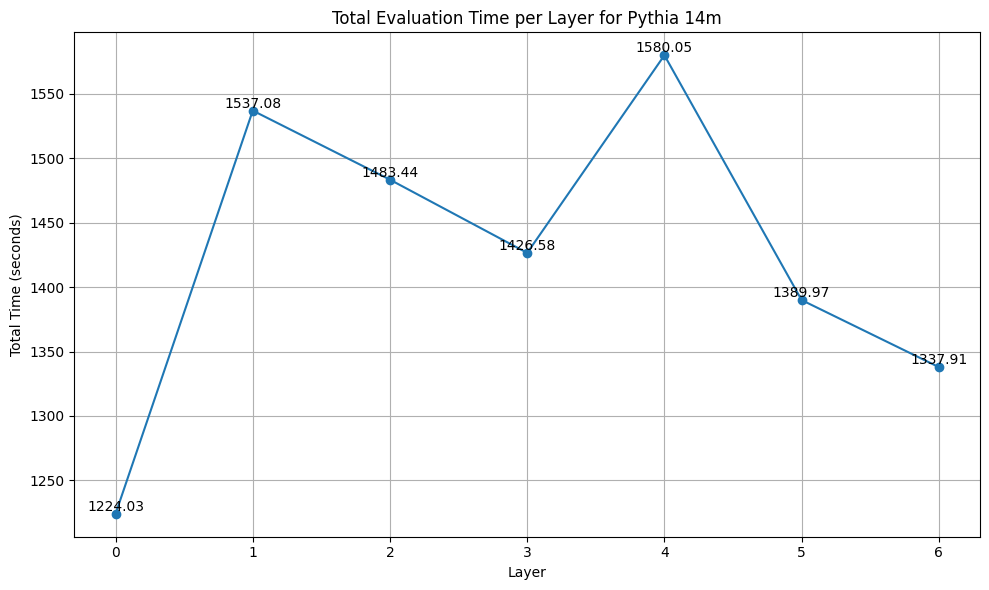

{0: 1224.0296988487244, 1: 1537.076404094696, 2: 1483.4417626857758, 3: 1426.5811371803284, 4: 1580.0492796897888, 5: 1389.9661979675293, 6: 1337.913664340973}


In [36]:
import matplotlib.pyplot as plt

total_time_elapsed_per_layer = {}
for dataset, data in results['mteb'].items():
    for layer, time in enumerate(data['time_elapsed']):
        if layer not in total_time_elapsed_per_layer:
            total_time_elapsed_per_layer[layer] = 0
        if time is not None:
            total_time_elapsed_per_layer[layer] += time

# Sort the dictionary by layer number
sorted_times = sorted(total_time_elapsed_per_layer.items())

# Separate layers and times for plotting
layers, times = zip(*sorted_times)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(layers, times, marker='o')
plt.title(f'Total Evaluation Time per Layer for {model_family} {model_size}')
plt.xlabel('Layer')
plt.ylabel('Total Time (seconds)')
plt.grid(True)

# Add text labels for each point
for layer, time in sorted_times:
    plt.text(layer, time, f'{time:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(total_time_elapsed_per_layer)


# One Model - Scores per layer per task

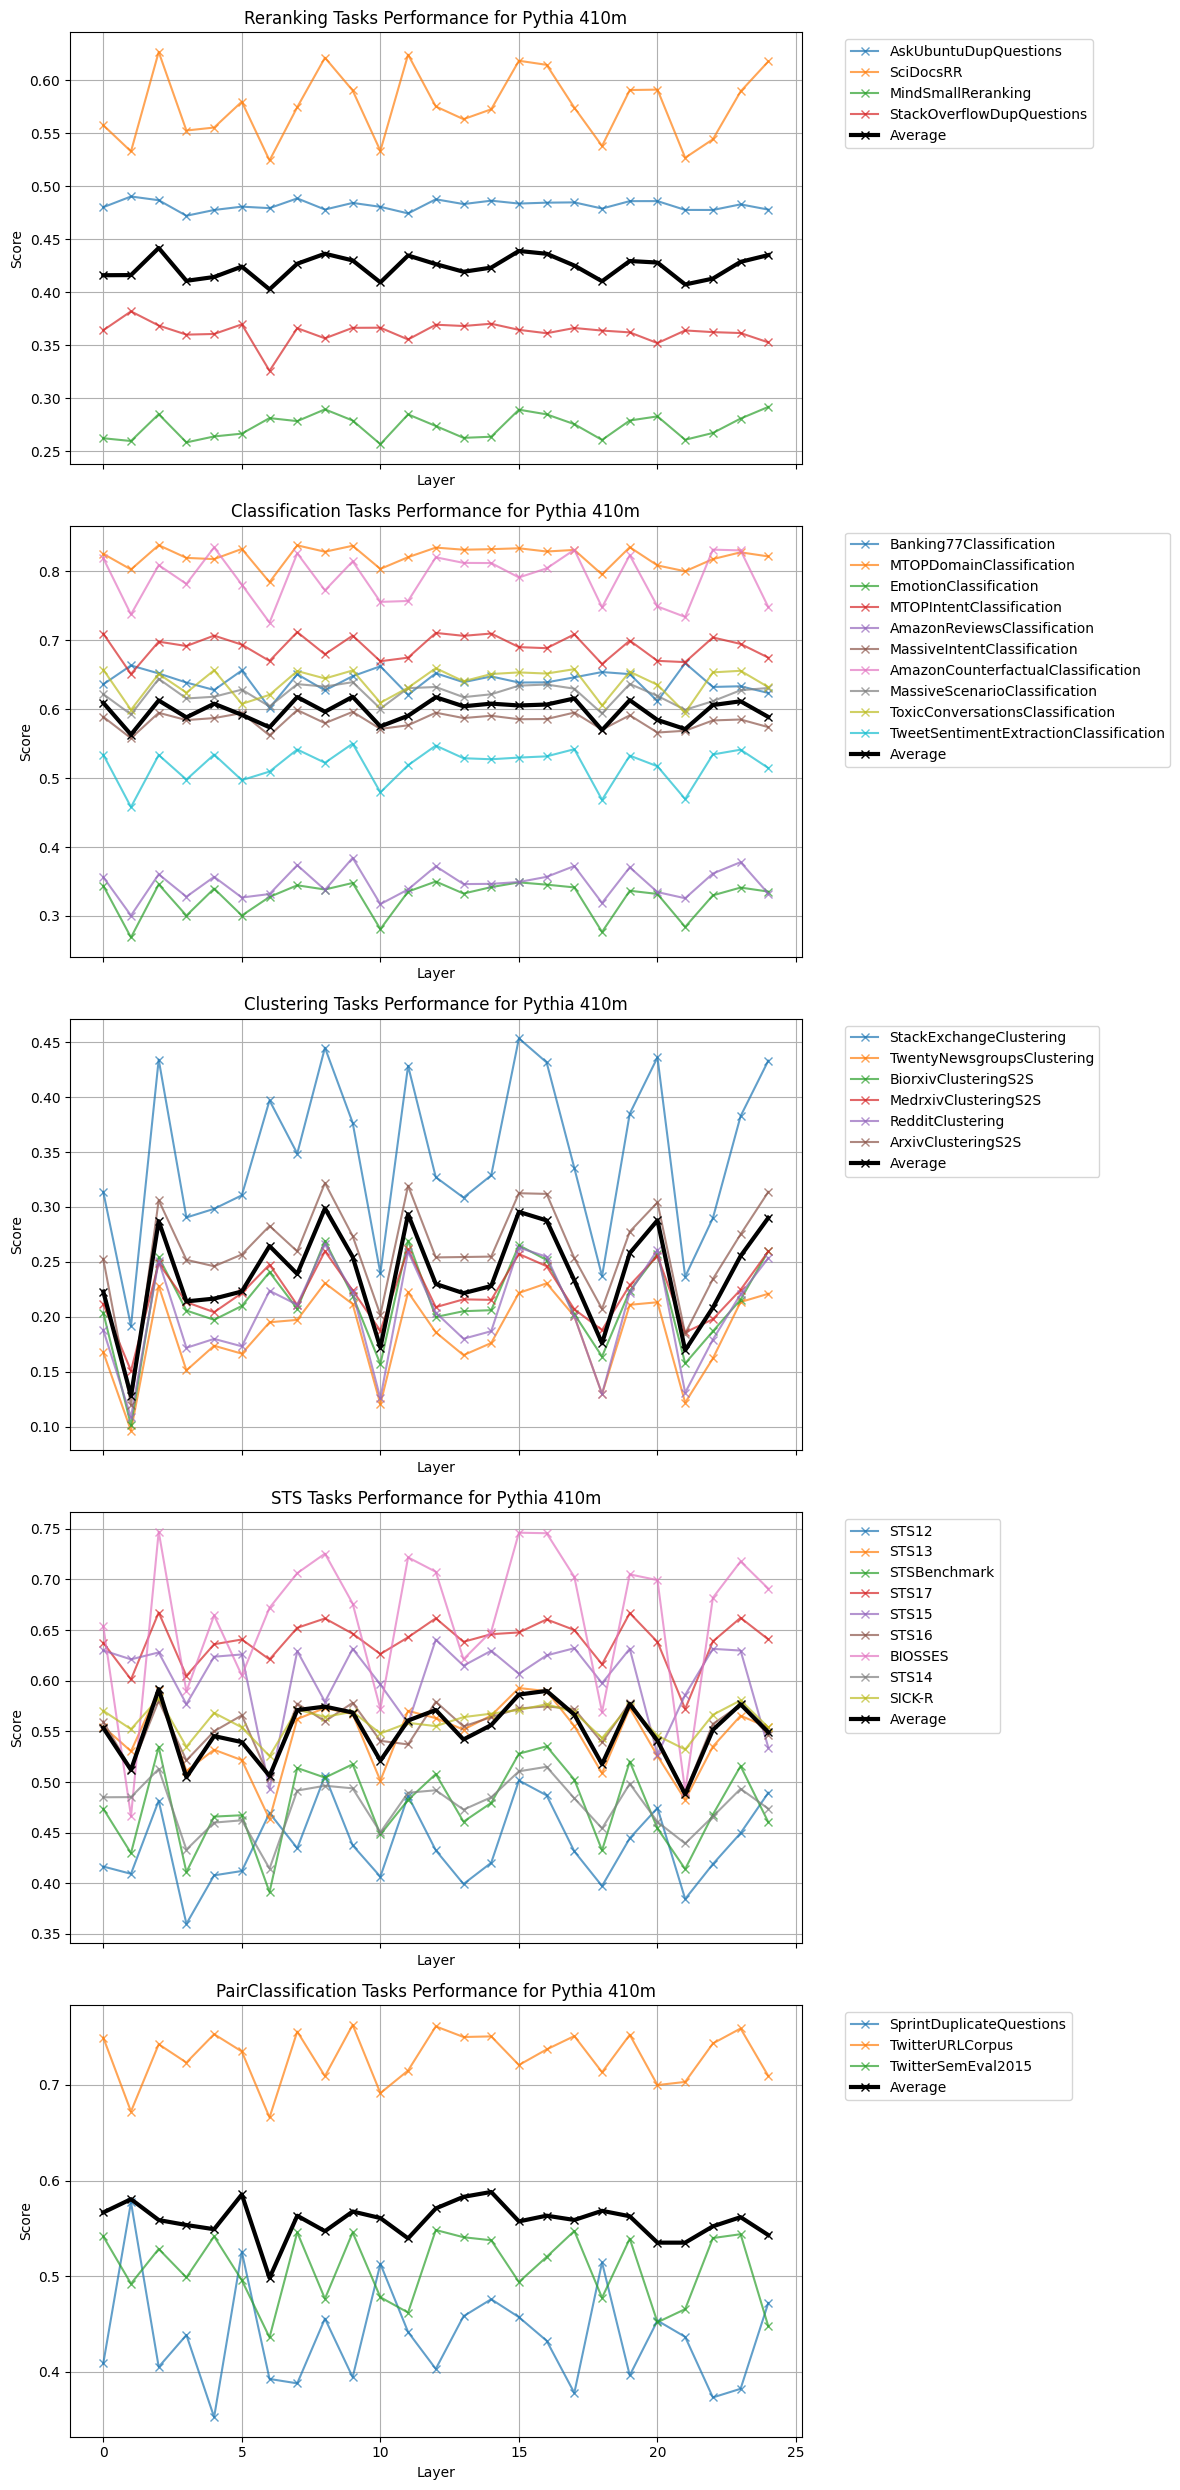

In [118]:
import matplotlib.pyplot as plt
import numpy as np

model_family = 'Pythia'
model_size = '410m'
revision = 'main'

model_specs = ModelSpecifications(model_family, model_size, revision=revision)
results = load_layerwise_results_for_specific_model(model_specs)

# Group tasks by task type
task_types = {}
for task, data in results['mteb'].items():
    task_type = data['task_type']
    if task_type not in task_types:
        task_types[task_type] = {}
    task_types[task_type][task] = data

# Create subplots
num_task_types = len(task_types)
fig, axs = plt.subplots(num_task_types, 1, figsize=(12, 5*num_task_types), sharex=True)

for i, (task_type, tasks) in enumerate(task_types.items()):
    ax = axs[i] if num_task_types > 1 else axs
    all_scores = []
    
    for task, data in tasks.items():
        scores = data['scores']
        layers = range(len(scores))
        ax.plot(layers, scores, label=task, alpha=0.7, marker='x')
        all_scores.append(scores)
    
    # Calculate and plot the average line
    if all_scores:
        average_scores = np.mean(all_scores, axis=0)
        ax.plot(layers, average_scores, label='Average', linewidth=3, color='black', marker='x')
    
    ax.set_xlabel('Layer')
    ax.set_ylabel('Score')
    ax.set_title(f'{task_type} Tasks Performance for {model_family} {model_size}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


# All models - Avg Score per layer per task type

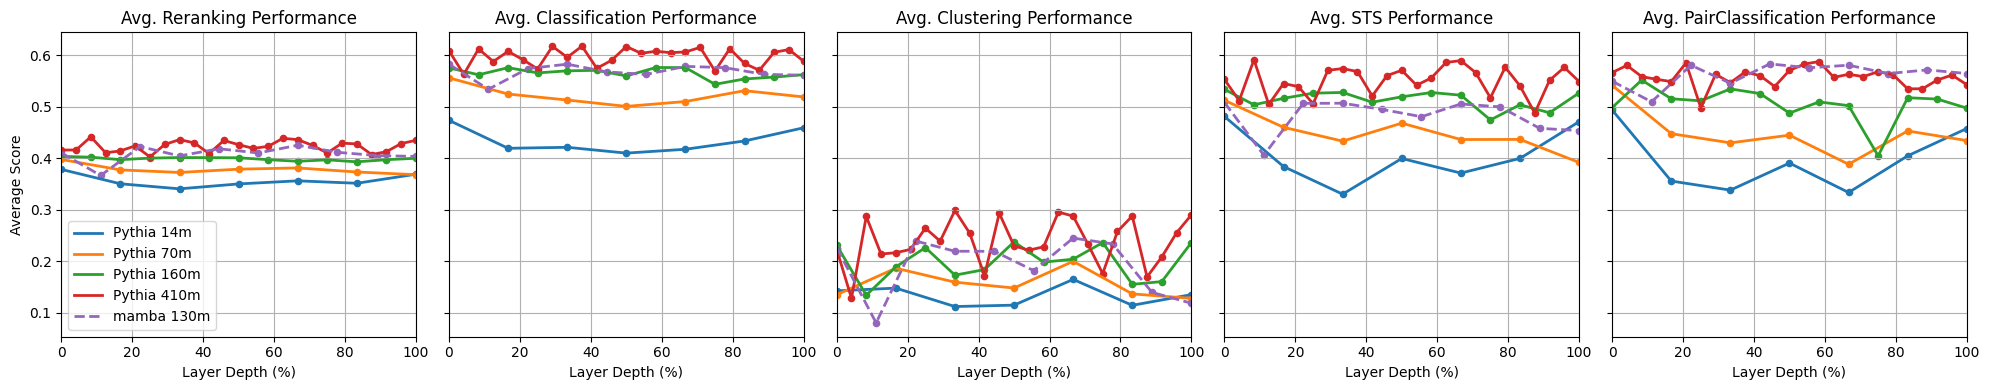

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Define model families and sizes
model_families = ['Pythia', 'mamba']  # Add or modify as needed
model_sizes = {
    'Pythia': ['14m', '70m', '160m', '410m'],
    'mamba': ['130m']
}

results = {}

# Load results for each model family and size
for family in model_families:
    results[family] = {}
    for size in model_sizes[family]:
        results[family][size] = load_layerwise_results_for_specific_model(ModelSpecifications(family, size, revision=revision))

# Group tasks by task type
task_types = {}
for family in model_families:
    for size in model_sizes[family]:
        for task, data in results[family][size]['mteb'].items():
            task_type = data['task_type']
            if task_type not in task_types:
                task_types[task_type] = {}
            if task not in task_types[task_type]:
                task_types[task_type][task] = {}
            if family not in task_types[task_type][task]:
                task_types[task_type][task][family] = {}
            task_types[task_type][task][family][size] = data

# Create subplots
num_task_types = len(task_types)
fig, axs = plt.subplots(1, num_task_types, figsize=(4*num_task_types, 4), sharey=True)

for i, (task_type, tasks) in enumerate(task_types.items()):
    ax = axs[i] if num_task_types > 1 else axs
    
    for family in model_families:
        for size in model_sizes[family]:
            all_scores = []
            max_layers = 0
            for task, family_data in tasks.items():
                if family in family_data and size in family_data[family]:
                    scores = family_data[family][size]['scores']
                    max_layers = max(max_layers, len(scores))
                    all_scores.append(scores)
            
            # Calculate and plot the average line and points for each size
            if all_scores:
                average_scores = np.mean(all_scores, axis=0)
                layers_percentage = np.linspace(0, 100, len(average_scores))
                linestyle = '--' if family == 'mamba' else '-'
                ax.plot(layers_percentage, average_scores, linewidth=2, linestyle=linestyle, label=f'{family} {size}')
                ax.scatter(layers_percentage, average_scores, s=20)
    ax.set_xlabel('Layer Depth (%)')
    if i == 0:
        ax.set_ylabel('Average Score')
        ax.legend()
    ax.set_title(f'Avg. {task_type} Performance')
       
    ax.grid(True)
    ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()


# One Model - Metrics per layer per task dataset

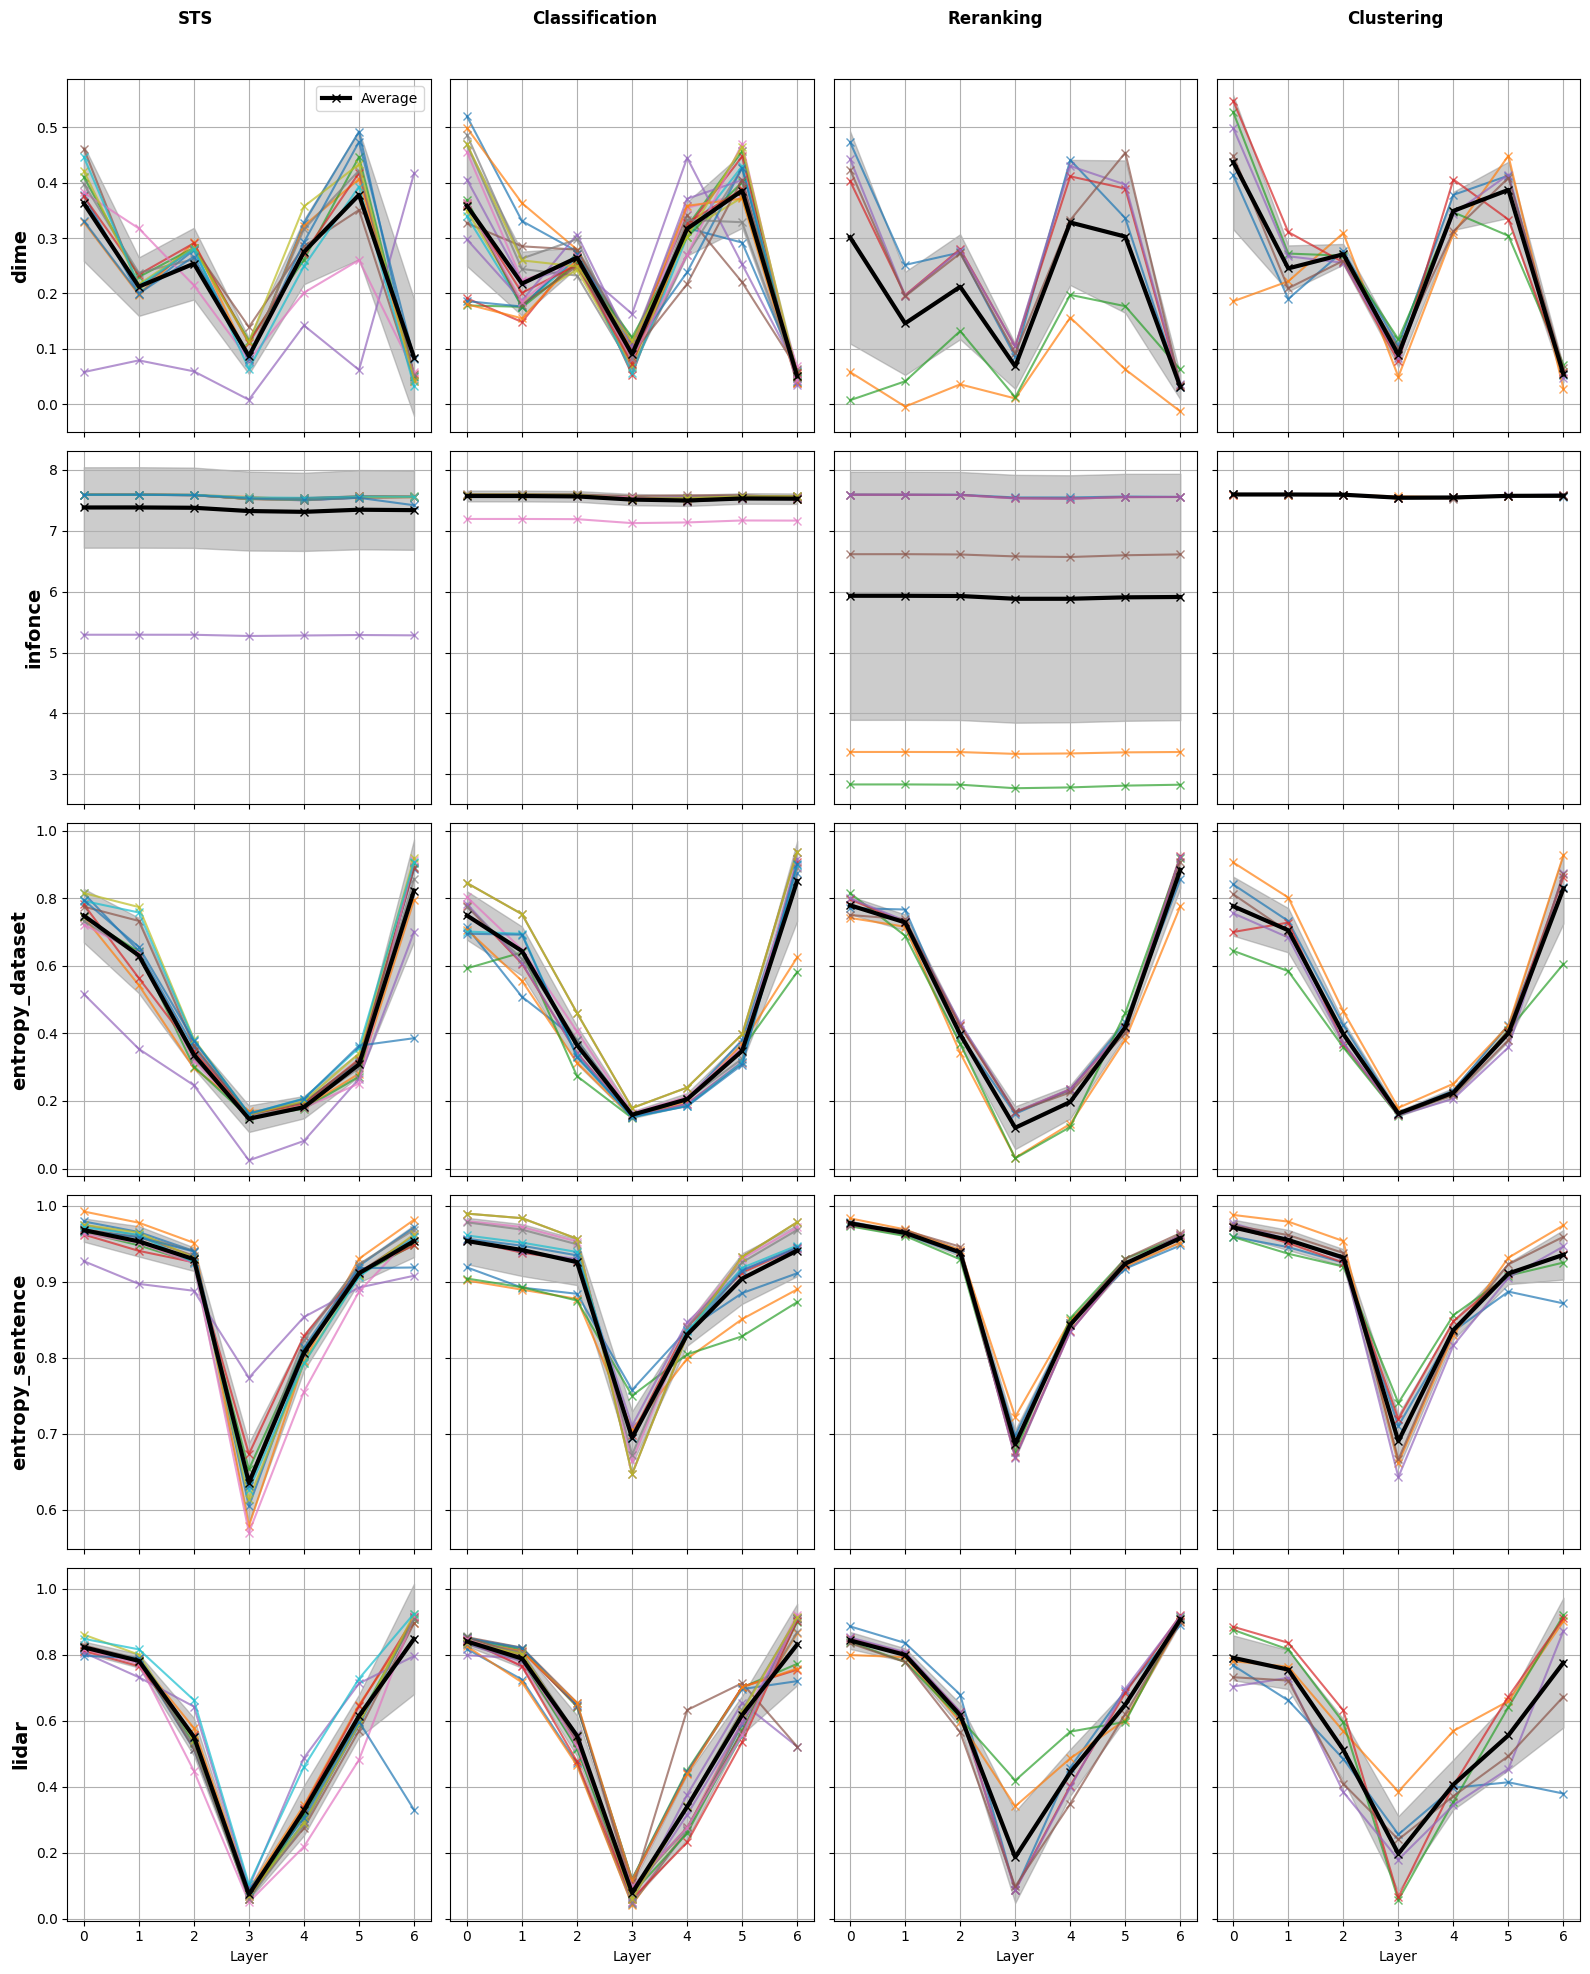

In [122]:
import matplotlib.pyplot as plt
import numpy as np

model_family = 'Pythia'
model_size = '14m'
revision = 'main'

PLOT_INDIVIDUAL_TASKS = True
PLOT_WIKITEXT = False

model_specs = ModelSpecifications(model_family, model_size, revision=revision)
results = load_layerwise_results_for_specific_model(model_specs)

# Group tasks by task type
task_types = {}
metrics = set()
wikitext_data = None
for task, data in results['metrics'].items():
    if task == 'wikitext':
        wikitext_data = data
        continue
    else:
        dataset_name = '/'.join(task.split('/')[0:2])
        # find the task with the same dataset name in the mteb results
        for mteb_task, mteb_data in results['mteb'].items():
            mteb_dataset_name = get_dataset_name_from_task_name(mteb_task)
            if mteb_dataset_name == dataset_name:
                task_type = mteb_data['task_type']
                break
    
    if task_type not in task_types:
        task_types[task_type] = {}
    task_types[task_type][task] = data
    metrics.update(data.keys())

# Remove curvature metric for now
metrics = {metric for metric in metrics if metric != 'curvature'}

# Create subplots
num_task_types = len(task_types)
num_metrics = len(metrics)
fig, axs = plt.subplots(num_metrics, num_task_types, figsize=(4*num_task_types, 4*num_metrics), sharex=True, sharey='row')

for i, metric in enumerate(metrics):
    for j, (task_type, tasks) in enumerate(task_types.items()):
        ax = axs[i, j] if num_metrics > 1 and num_task_types > 1 else axs[i] if num_metrics > 1 else axs[j] if num_task_types > 1 else axs
        all_metric_values = []
        if PLOT_INDIVIDUAL_TASKS:
            for task, data in tasks.items():
                if metric in data.keys():
                    metric_values = data[metric]
                    normalization_type = 'maxEntropy' if 'maxEntropy' in metric_values.keys() else 'raw'
                    metric_values = metric_values[normalization_type]
                    
                    layers = range(len(metric_values))
                    ax.plot(layers, metric_values, alpha=0.7, marker='x')
                    all_metric_values.append(metric_values)
        else:
            for task, data in tasks.items():
                if metric in data.keys():
                    metric_values = data[metric]
                    normalization_type = 'maxEntropy' if 'maxEntropy' in metric_values.keys() else 'raw'
                    metric_values = metric_values[normalization_type]
                    all_metric_values.append(metric_values)
        
        # Add wikitext data to every subplot if PLOT_WIKITEXT is True
        if PLOT_WIKITEXT and wikitext_data and metric in wikitext_data.keys():
            wikitext_values = wikitext_data[metric]
            normalization_type = 'maxEntropy' if 'maxEntropy' in wikitext_values.keys() else 'raw'
            wikitext_values = wikitext_values[normalization_type]
            ax.plot(layers, wikitext_values, label='wikitext', linestyle='--', color='red', linewidth=2, marker='x')
        
        # Calculate and plot the average line with standard deviation
        if all_metric_values:
            average_values = np.mean(all_metric_values, axis=0)
            std_values = np.std(all_metric_values, axis=0)
            ax.plot(layers, average_values, label='Average', linewidth=3, color='black', marker='x')
            ax.fill_between(layers, average_values - std_values, average_values + std_values, alpha=0.4, color='gray')
        ax.grid(True)

        # Only set the y-label for the leftmost subplot in each row
        if j == 0:
            ax.set_ylabel(metric, fontsize=14, fontweight='bold')
        
        # Only set the x-label for the bottom subplot in each column
        if i == num_metrics - 1:
            ax.set_xlabel('Layer')
        
        if i == 0 and j == 0:
            ax.legend()

# Add task type labels on top of each column
for j, task_type in enumerate(task_types.keys()):
    fig.text((j + 0.5) / num_task_types, 0.98, task_type, ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top margin to accommodate task type labels
plt.show()


# One Model - Average task type metrics plotted together

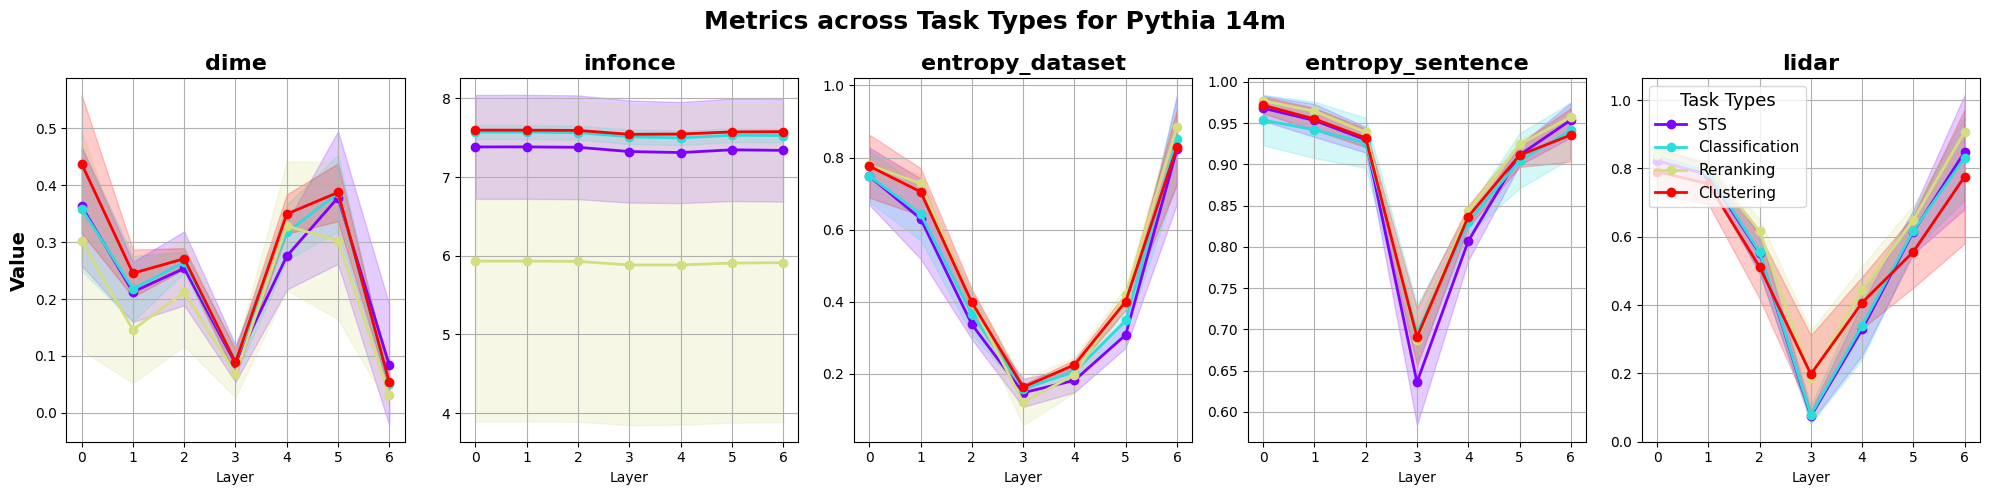

In [123]:
import matplotlib.pyplot as plt
import numpy as np

model_family = 'Pythia'
model_size = '14m'
revision = 'main'

model_specs = ModelSpecifications(model_family, model_size, revision=revision)
results = load_layerwise_results_for_specific_model(model_specs)

# Group tasks by task type
task_types = {}
metrics = set()
wikitext_data = None
for task, data in results['metrics'].items():
    if task == 'wikitext':
        wikitext_data = data
        continue
    else:
        dataset_name = '/'.join(task.split('/')[0:2])
        # find the task with the same dataset name in the mteb results
        for mteb_task, mteb_data in results['mteb'].items():
            mteb_dataset_name = get_dataset_name_from_task_name(mteb_task)
            if mteb_dataset_name == dataset_name:
                task_type = mteb_data['task_type']
                break
    
    if task_type not in task_types:
        task_types[task_type] = {}
    task_types[task_type][task] = data
    metrics.update(data.keys())

# Remove curvature metric for now
metrics = {metric for metric in metrics if metric != 'curvature'}

# Create subplots
num_metrics = len(metrics)
fig, axs = plt.subplots(1, num_metrics, figsize=(4*num_metrics, 5), sharey=False)

colors = plt.cm.rainbow(np.linspace(0, 1, len(task_types)))
task_type_colors = dict(zip(task_types.keys(), colors))

PLOT_WIKITEXT = False

for i, metric in enumerate(metrics):
    ax = axs[i] if num_metrics > 1 else axs
    
    for task_type, tasks in task_types.items():
        all_metric_values = []
        for task, data in tasks.items():
            if metric in data.keys():
                metric_values = data[metric]
                normalization_type = 'maxEntropy' if 'maxEntropy' in metric_values.keys() else 'raw'
                metric_values = metric_values[normalization_type]
                all_metric_values.append(metric_values)
        
        # Calculate and plot the average line with standard deviation
        if all_metric_values:
            average_values = np.mean(all_metric_values, axis=0)
            std_values = np.std(all_metric_values, axis=0)
            ax.plot(layers, average_values, label=task_type, linewidth=2, color=task_type_colors[task_type], marker='o')
            ax.fill_between(layers, average_values - std_values, average_values + std_values, alpha=0.2, color=task_type_colors[task_type])
    
    # Add wikitext data to every subplot if plot_wikitext is True
    if PLOT_WIKITEXT and wikitext_data and metric in wikitext_data.keys():
        wikitext_values = wikitext_data[metric]
        normalization_type = 'maxEntropy' if 'maxEntropy' in wikitext_values.keys() else 'raw'
        wikitext_values = wikitext_values[normalization_type]
        ax.plot(layers, wikitext_values, label='wikitext', linestyle='--', color='red', linewidth=2, marker='x')
    
    ax.grid(True)
    ax.set_xlabel('Layer')
    ax.set_title(f'{metric}', fontsize=16, fontweight='bold')
    
    # Only set the y-label for the leftmost subplot
    if i == 0:
        ax.set_ylabel('Value', fontsize=14, fontweight='bold')
    
    # Only show the legend for the rightmost subplot
    if i == num_metrics - 1:
        ax.legend(title='Task Types', title_fontsize='13', fontsize='11', loc='upper left')

plt.suptitle(f'Metrics across Task Types for {model_family} {model_size}', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# All Models - Comparison against different task types

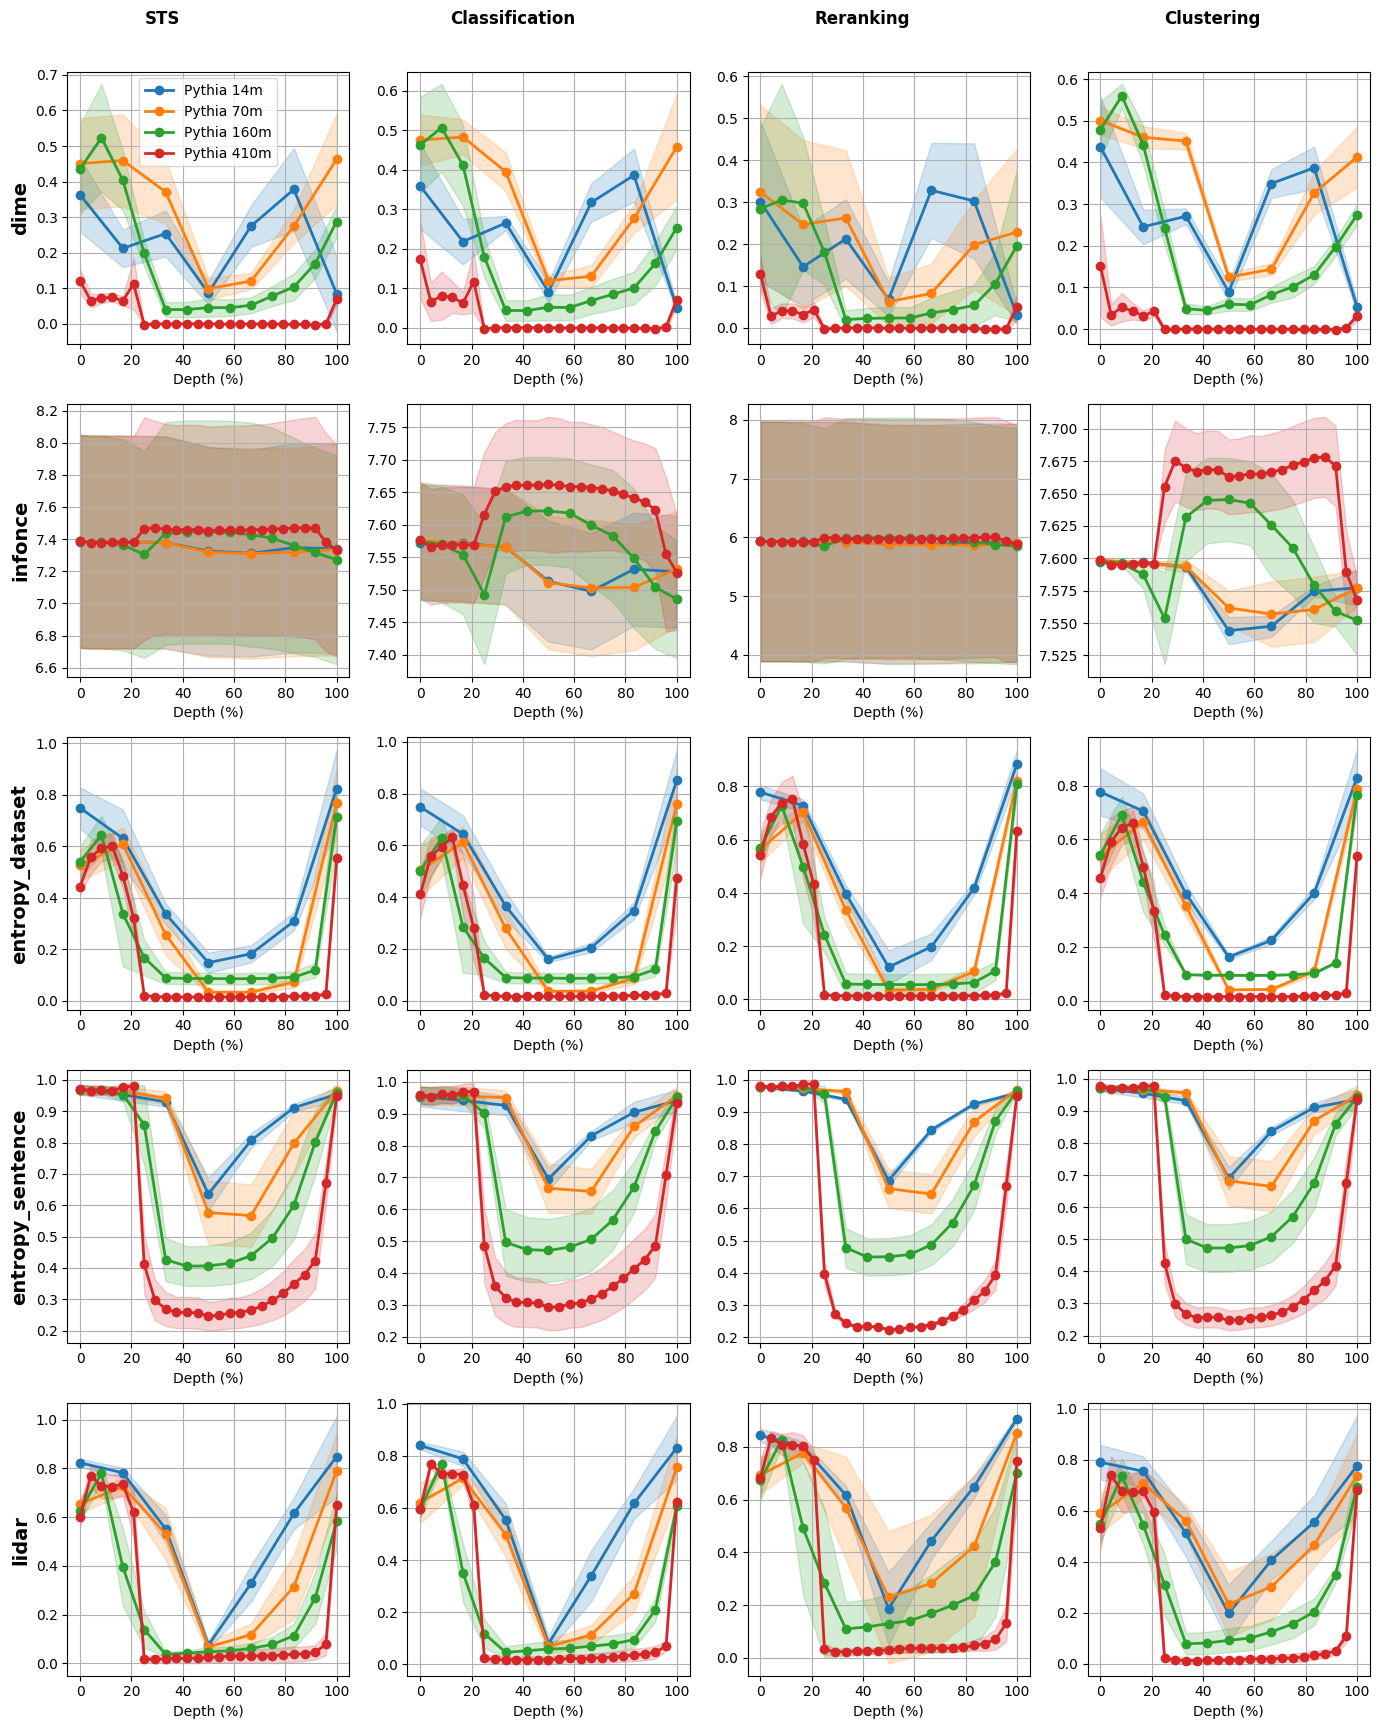

In [132]:
model_families = ['Pythia', 'mamba']  # Add or modify as needed
model_sizes = {
    'Pythia': ['14m', '70m', '160m', '410m'],
    'mamba': ['130m']
}

USE_DEPTH_PERCENTAGE = True
USE_WIKITEXT = False

results = {}

# Load results for all models
for model_family in model_families:
    for model_size in model_sizes[model_family]:
        revision = 'main'
        model_specs = ModelSpecifications(model_family, model_size, revision=revision)
        results[(model_family, model_size)] = load_layerwise_results_for_specific_model(model_specs)

# Group tasks by task type
task_types = {}
metrics = set()
wikitext_data = {}
for (model_family, model_size), model_results in results.items():
    for task, data in model_results['metrics'].items():
        if task == 'wikitext':
            wikitext_data[(model_family, model_size)] = data
            continue
        else:
            dataset_name = '/'.join(task.split('/')[0:2])
            # find the task with the same dataset name in the mteb results
            for mteb_task, mteb_data in model_results['mteb'].items():
                mteb_dataset_name = get_dataset_name_from_task_name(mteb_task)
                if mteb_dataset_name == dataset_name:
                    task_type = mteb_data['task_type']
                    break
        
        if task_type not in task_types:
            task_types[task_type] = {}
        if (model_family, model_size) not in task_types[task_type]:
            task_types[task_type][(model_family, model_size)] = {}
        task_types[task_type][(model_family, model_size)][task] = data
        metrics.update(data.keys())

# Remove curvature metric for now
metrics = {metric for metric in metrics if metric != 'curvature'}

# Create subplots
num_metrics = len(metrics)
num_task_types = len(task_types)
fig, axs = plt.subplots(num_metrics, num_task_types, figsize=(3.5*num_task_types, 3.5*num_metrics))

PLOT_WIKITEXT = False

for i, metric in enumerate(metrics):
    for j, (task_type, models) in enumerate(task_types.items()):
        ax = axs[i, j] if num_metrics > 1 and num_task_types > 1 else axs[i] if num_task_types == 1 else axs[j] if num_metrics == 1 else axs
        
        for (model_family, model_size), tasks in models.items():
            all_metric_values = []
            for task, data in tasks.items():
                if metric in data.keys():
                    metric_values = data[metric]
                    normalization_type = 'maxEntropy' if 'maxEntropy' in metric_values.keys() else 'raw'
                    metric_values = metric_values[normalization_type]
                    all_metric_values.append(metric_values)
            
            # Calculate and plot the average line with standard deviation
            if all_metric_values:
                num_layers = len(all_metric_values[0])
                depth_percentage = np.linspace(0, 100, num_layers)
                average_values = np.mean(all_metric_values, axis=0)
                std_values = np.std(all_metric_values, axis=0)
                line, = ax.plot(depth_percentage, average_values, label=f'{model_family} {model_size}', linewidth=2, marker='o')
                ax.fill_between(depth_percentage, average_values - std_values, average_values + std_values, alpha=0.2, color=line.get_color())
        
        # Add wikitext data to every subplot if plot_wikitext is True
        if PLOT_WIKITEXT:
            for (model_family, model_size), data in wikitext_data.items():
                if metric in data.keys():
                    wikitext_values = data[metric]
                    normalization_type = 'maxEntropy' if 'maxEntropy' in wikitext_values.keys() else 'raw'
                    wikitext_values = wikitext_values[normalization_type]
                    num_layers = len(wikitext_values)
                    depth_percentage = np.linspace(0, 100, num_layers)
                    ax.plot(depth_percentage, wikitext_values, label=f'{model_family} {model_size} (wikitext)', linestyle='--', linewidth=2, marker='x')
        
        ax.grid(True)
        ax.set_xlabel('Depth (%)')
       # Only set the y-label for the leftmost subplot in each row
        if j == 0:
            ax.set_ylabel(metric, fontsize=14, fontweight='bold')
        
        if i == 0 and j == 0:
            ax.legend()

# Add task type labels on top of each column
for j, task_type in enumerate(task_types.keys()):
    fig.text((j + 0.5) / num_task_types, 0.98, task_type, ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top margin to accommodate task type labels
plt.show()


# All Models - Compute Correlations between Metrics and performance

In [189]:
#model_families = ['Pythia', 'mamba']  # Add or modify as needed
# model_sizes = {
#     'Pythia': ['14m', '70m', '160m', '410m'],
#     'mamba': ['130m']
# }

model_families = ['Pythia']  # Add or modify as needed
model_sizes = {
    'Pythia': ['410m'],
    'mamba': ['130m']
}

USE_DEPTH_PERCENTAGE = True
USE_WIKITEXT = False

results = {}

# Load results for all models
for model_family in model_families:
    for model_size in model_sizes[model_family]:
        revision = 'main'
        model_specs = ModelSpecifications(model_family, model_size, revision=revision)
        results[(model_family, model_size)] = load_layerwise_results_for_specific_model(model_specs)

# Group tasks by task type
task_types = {}
metrics = set()
wikitext_data = {}
for (model_family, model_size), model_results in results.items():
    for task, data in model_results['metrics'].items():
        if task == 'wikitext':
            continue
        else:
            dataset_name = '/'.join(task.split('/')[0:2])
            # find the task with the same dataset name in the mteb results
            for mteb_task, mteb_data in model_results['mteb'].items():
                mteb_dataset_name = get_dataset_name_from_task_name(mteb_task)
                if mteb_dataset_name == dataset_name:
                    task_type = mteb_data['task_type']
                    break
        
        if task_type not in task_types:
            task_types[task_type] = {}
        if (model_family, model_size) not in task_types[task_type]:
            task_types[task_type][(model_family, model_size)] = {}
        task_types[task_type][(model_family, model_size)][task] = data
        metrics.update(data.keys())

# Remove curvature metric for now
metrics = {metric for metric in metrics if metric != 'curvature'}

In [195]:
from scipy.stats import spearmanr

# Initialize a dictionary to store metric-score pairs for each dataset
metric_score_pairs = {}

# Iterate through each model's results
for (model_family, model_size), model_results in results.items():
    for dataset, dataset_data in model_results['metrics'].items():
        if dataset == 'wikitext':
            continue
            
        # Map dataset name to task name
        task_name = None
        dataset_name = '/'.join(dataset.split('/')[0:2])
        for mteb_task, mteb_data in model_results['mteb'].items():
            if get_dataset_name_from_task_name(mteb_task) == dataset_name:
                task_name = mteb_task
                break
        
        if task_name is None:
            print(f"Warning: No matching task found for dataset {dataset}")
            continue
        
        GET_ALL_PAIRS = True

        if not GET_ALL_PAIRS:
            # Get the performance data for this dataset
            performance = model_results['mteb'][task_name]['scores'][-1]
        
            # Iterate through each metric
            for metric in metrics:
                if metric in dataset_data:
                    metric_values = dataset_data[metric]
                    normalization_type = 'raw' if 'maxEntropy' in metric_values.keys() else 'raw'
                    metric_values = metric_values[normalization_type]

                    last_layer_score = metric_values[-1]
                    
                    if metric not in metric_score_pairs:
                        metric_score_pairs[metric] = []
                    
                    # Append the (metric score, performance) pair
                    metric_score_pairs[metric].append((last_layer_score, performance))
        else:
            performance = model_results['mteb'][task_name]['scores']
            # Get all pairs
            for metric in metrics:
                if metric in dataset_data:
                    metric_values = dataset_data[metric]
                    normalization_type = 'raw' if 'maxEntropy' in metric_values.keys() else 'raw'
                    metric_values = metric_values[normalization_type]
                    
                    for idx in range(len(metric_values)):
                        if idx not in metric_score_pairs:
                            metric_score_pairs[idx] = {}
                        if metric not in metric_score_pairs[idx]:
                            metric_score_pairs[idx][metric] = []
                        # Append the (metric score, performance) pair
                        metric_score_pairs[idx][metric].append((metric_values[idx], performance[idx]))

if GET_ALL_PAIRS:
    correlation_matrix = {}
    for layer_idx, layer_data in metric_score_pairs.items():
        if layer_idx not in correlation_matrix:
            correlation_matrix[layer_idx] = {}

        for metric, pairs in layer_data.items():
            if metric not in correlation_matrix[layer_idx]:
                correlation_matrix[layer_idx][metric] = []

            x = [pair[0] for pair in pairs]
            y = [pair[1] for pair in pairs]
            correlation_matrix[layer_idx][metric], _ = spearmanr(x, y)
else:
    # Compute Spearman correlation coefficient for each metric-dataset pair
    correlation_matrix = {}
    for metric, pairs in metric_score_pairs.items():
        x = [pair[0] for pair in pairs]
        y = [pair[1] for pair in pairs]
        correlation_matrix[metric], _ = spearmanr(x, y)


In [ ]:
(entropy, performance)_task

In [198]:
if GET_ALL_PAIRS:
    for layer_idx, layer_data in correlation_matrix.items():
        if layer_idx == len(correlation_matrix) - 1:
            print(f"Layer {layer_idx}:")
            for metric, correlation in layer_data.items():
                print(f"  {metric}: {correlation:.4f}")
else:
    for metric, correlation in correlation_matrix.items():
        print(f"{metric}: {correlation:.4f}")

Layer 24:
  dime: 0.6203
  infonce: -0.2571
  entropy_dataset: 0.2338
  entropy_sentence: -0.1115
  lidar: -0.3401


In [199]:
# Extract InfoNCE and performance data
infonce_scores = [pair[0] for pair in metric_score_pairs['infonce']]
performance_scores = [pair[1] for pair in metric_score_pairs['infonce']]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(infonce_scores, performance_scores, alpha=0.6)
plt.xlabel('InfoNCE Score')
plt.ylabel('Performance')
plt.title('InfoNCE vs Performance')

# Add a trend line
z = np.polyfit(infonce_scores, performance_scores, 1)
p = np.poly1d(z)
plt.plot(infonce_scores, p(infonce_scores), "r--", alpha=0.8)

# Add correlation coefficient to the plot
correlation, _ = spearmanr(infonce_scores, performance_scores)
plt.text(0.05, 0.95, f'Spearman correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()


KeyError: 'infonce'